In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

PATHS = {
    'train': 'https://gabrielraian-bucket.s3.sa-east-1.amazonaws.com/train.csv',
    'test_folder': 'https://gabrielraian-bucket.s3.sa-east-1.amazonaws.com/test',
    'sample_submission': 'https://gabrielraian-bucket.s3.sa-east-1.amazonaws.com/sample_submission.csv'
}


In [2]:
def extrair_features_avancadas(dados_acusticos):
    x = np.array(dados_acusticos)

    features = {
        'mean': np.mean(x),                                   # Média do sinal — nível médio das vibrações
        'std': np.std(x),                                     # Desvio padrão — quão intenso e variável é o tremor
        'min': np.min(x),                                     # Menor valor — pico negativo mais extremo
        'max': np.max(x),                                     # Maior valor — pico positivo mais extremo
        'median': np.median(x),                               # Mediana — centro robusto do sinal
        'q25': np.quantile(x, 0.25),                          # 1º quartil — 25% dos valores abaixo deste ponto
        'q75': np.quantile(x, 0.75),                          # 3º quartil — 75% dos valores abaixo deste ponto
        'iqr': np.quantile(x, 0.75) - np.quantile(x, 0.25),   # Amplitude interquartílica — dispersão resistente a outliers
        'skewness': pd.Series(x).skew(),                      # Assimetria — se o sinal é puxado para um lado
        'kurtosis': pd.Series(x).kurtosis(),                  # Curtose — "pontudos" dos picos (atividade sísmica gera alta curtose)
        'abs_mean': np.mean(np.abs(x)),                       # Média do valor absoluto — energia média do tremor
        'abs_energy': np.sum(x ** 2),                         # Energia total do sinal — intensidade global
        'abs_max': np.max(np.abs(x)),                         # Maior amplitude absoluta — maior pico registrado
        'zero_crossing_rate': np.sum(np.diff(np.sign(x)) != 0) / len(x),   # Taxa de cruzamento por zero — frequência de vibração
        'mean_abs_diff': np.mean(np.abs(np.diff(x))),         # Diferença absoluta média — velocidade das mudanças no tremor
        'rolling_std_100': pd.Series(x).rolling(100, min_periods=1).std().mean(),   # Média da volatilidade local (janela 100)
        'rolling_mean_100': pd.Series(x).rolling(100, min_periods=1).mean().mean(), # Média do nível local (janela 100)
        'entropy': -np.sum(np.histogram(x, bins=20, density=True)[0] *
                           np.log2(np.histogram(x, bins=20, density=True)[0] + 1e-10)),   # Entropia — aleatoriedade do sinal
        'range': np.max(x) - np.min(x),                       # Amplitude total — distância entre pico máximo e mínimo
        'autocorr_lag1': pd.Series(x).autocorr(lag=1),        # Autocorrelação (lag 1) — quanto o sinal se parece com ele mesmo
    }

    return features


In [3]:
def processar_treinamento(file_path, segment_length=150000, max_segments=200):
    print(f"\nPROCESSANDO ARQUIVO DE TREINAMENTO...")
    print(f"Segmentos: {max_segments}, Tamanho: {segment_length} amostras")

    features_list = []
    targets_list = []
    segment_count = 0

    try:
        for chunk in tqdm(pd.read_csv(file_path, chunksize=segment_length),
                         total=max_segments, desc="Processando"):

            if len(chunk) < segment_length:
                continue

            features = extrair_features_avancadas(chunk['acoustic_data'])
            target = chunk['time_to_failure'].iloc[-1]

            features_list.append(features)
            targets_list.append(target)
            segment_count += 1

            if segment_count >= max_segments:
                break

    except Exception as e:
        print(f"Erro no processamento: {e}")

    X = pd.DataFrame(features_list)
    y = np.array(targets_list)

    print(f"Treinamento: {X.shape[0]} segmentos, {X.shape[1]} features")
    return X, y

print("Iniciando processamento do train.csv...")
X_treino, y_treino = processar_treinamento(PATHS['train'])
print("Processamento de treino concluído!")

Iniciando processamento do train.csv...

PROCESSANDO ARQUIVO DE TREINAMENTO...
Segmentos: 200, Tamanho: 150000 amostras


Processando: 100%|█████████▉| 199/200 [00:19<00:00, 10.30it/s]


Treinamento: 200 segmentos, 20 features
Processamento de treino concluído!


In [4]:
def treinar_avaliar_modelo(X, y, val_size=0.2):
    print(f"\nTreinando o algoritmo...")

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=val_size, random_state=42, shuffle=True
    )

    print(f"Treino: {X_train.shape[0]} amostras")
    print(f"Validação: {X_val.shape[0]} amostras")

    modelo = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    modelo.fit(X_train, y_train)
    print("Modelo treinado!")

    pred_train = modelo.predict(X_train)
    pred_val = modelo.predict(X_val)

    mae_train = mean_absolute_error(y_train, pred_train)
    mae_val = mean_absolute_error(y_val, pred_val)

    print(f"\nRESULTADOS:")
    print(f"MAE Treino: {mae_train:.4f} segundos")
    print(f"MAE Validação: {mae_val:.4f} segundos")

    return modelo, X_train, X_val, y_train, y_val

modelo, X_train, X_val, y_train, y_val = treinar_avaliar_modelo(X_treino, y_treino)


Treinando o algoritmo...
Treino: 160 amostras
Validação: 40 amostras
Modelo treinado!

RESULTADOS:
MAE Treino: 0.9038 segundos
MAE Validação: 0.9966 segundos


Gerando visualizações...
Visualizações concluídas!


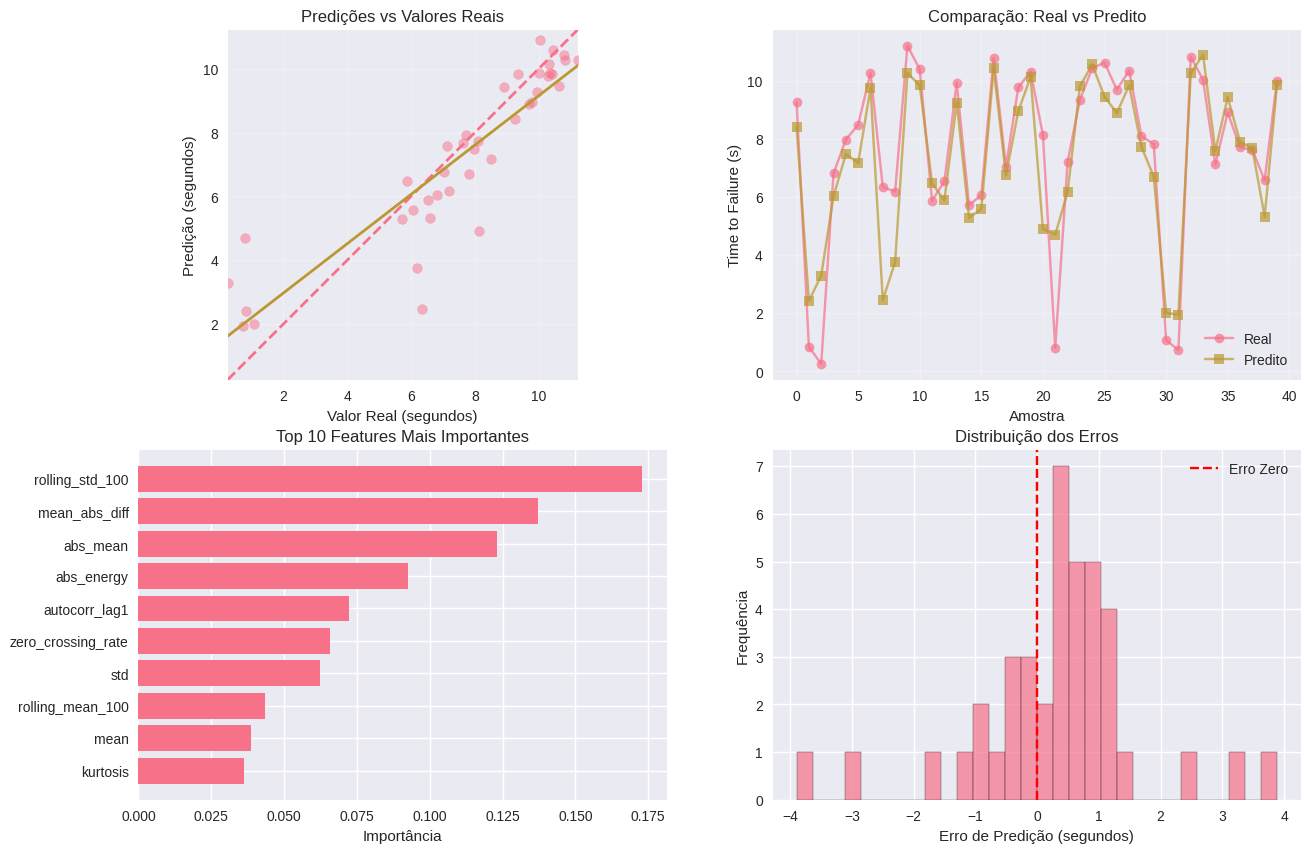

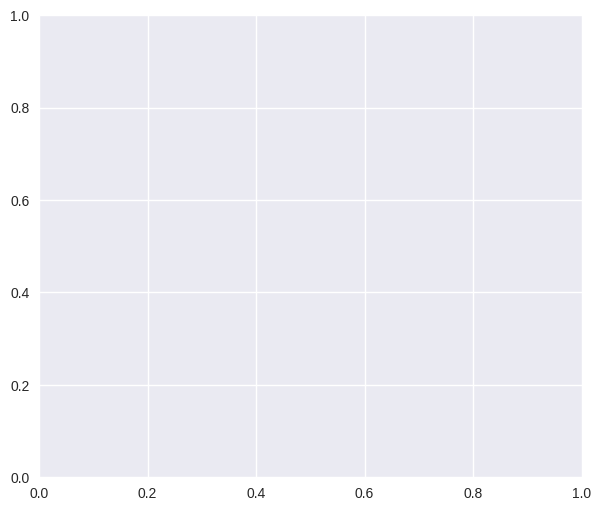

In [10]:
def visualizar_resultados(modelo, X_val, y_val):
    pred_val = modelo.predict(X_val)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    fig, ax = plt.subplots(figsize=(7, 6))

    # Predições vs Reais
    ax = axes[0, 0]
    ax.scatter(y_val, pred_val, alpha=0.5)
    min_val = min(y_val.min(), pred_val.min())
    max_val = max(y_val.max(), pred_val.max())
    ax.plot([min_val, max_val], [min_val, max_val], '--', linewidth=2)
    coef = np.polyfit(y_val, pred_val, 1)
    poly = np.poly1d(coef)
    ax.plot([min_val, max_val], poly([min_val, max_val]), linewidth=2)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Valor Real (segundos)')
    ax.set_ylabel('Predição (segundos)')
    ax.set_title('Predições vs Valores Reais')
    ax.grid(True, alpha=0.25)

    # Série temporal (primeiras 50 amostras)
    axes[0, 1].plot(y_val[:50], label='Real', marker='o', alpha=0.7)
    axes[0, 1].plot(pred_val[:50], label='Predito', marker='s', alpha=0.7)
    axes[0, 1].set_xlabel('Amostra')
    axes[0, 1].set_ylabel('Time to Failure (s)')
    axes[0, 1].set_title('Comparação: Real vs Predito')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Importância das features
    importancias = modelo.feature_importances_
    indices = np.argsort(importancias)[-10:]
    axes[1, 0].barh(range(len(indices)), importancias[indices])
    axes[1, 0].set_yticks(range(len(indices)))
    axes[1, 0].set_yticklabels([X_val.columns[i] for i in indices])
    axes[1, 0].set_xlabel('Importância')
    axes[1, 0].set_title('Top 10 Features Mais Importantes')

    # Distribuição dos erros
    erros = y_val - pred_val
    axes[1, 1].hist(erros, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', label='Erro Zero')
    axes[1, 1].set_xlabel('Erro de Predição (segundos)')
    axes[1, 1].set_ylabel('Frequência')
    axes[1, 1].set_title('Distribuição dos Erros')
    axes[1, 1].legend()

    return pred_val

print("Gerando visualizações...")
pred_val = visualizar_resultados(modelo, X_val, y_val)
print("Visualizações concluídas!")

In [6]:
def processar_teste_via_url(base_url, sample_submission_path, max_test_files=None):
    print("\nProcessando dados de teste via URL S3...")

    sample_sub = pd.read_csv(sample_submission_path)
    seg_ids = sample_sub['seg_id'].tolist()

    if max_test_files:
        seg_ids = seg_ids[:max_test_files]

    print(f"Total de arquivos a baixar: {len(seg_ids)}")

    features_teste = []
    seg_ids_processados = []

    for seg_id in tqdm(seg_ids, desc="Baixando e processando"):
        url_csv = f"{base_url}/{seg_id}.csv"

        try:
            dados_teste = pd.read_csv(url_csv)
            features = extrair_features_avancadas(dados_teste['acoustic_data'])

            features_teste.append(features)
            seg_ids_processados.append(seg_id)

        except Exception as e:
            print(f"❌ Erro no {seg_id}: {e}")

    X_teste = pd.DataFrame(features_teste)
    print(f"\nProcessado: {X_teste.shape[0]} segmentos")

    return X_teste, seg_ids_processados

X_teste, seg_ids = processar_teste_via_url(
  base_url=PATHS['test_folder'],
  sample_submission_path=PATHS['sample_submission']
)


Processando dados de teste via URL S3...
Total de arquivos a baixar: 2624


Baixando e processando: 100%|██████████| 2624/2624 [46:17<00:00,  1.06s/it]


Processado: 2624 segmentos


In [7]:
def criar_submissao_kaggle(modelo, X_teste, seg_ids):
    if X_teste is None or seg_ids is None:
        print("Dados de teste não disponíveis para submissão")
        return None

    predicoes_teste = modelo.predict(X_teste)

    submissao = pd.DataFrame({
        'seg_id': seg_ids,
        'time_to_failure': predicoes_teste
    })

    print(f"Submissão criada com {len(submissao)} predições")
    print(f"\nAmostra da submissão:")
    print(submissao.head(10))

    submissao.to_csv('minha_submissao.csv', index=False)
    print("Arquivo salvo: 'minha_submissao.csv'")

    return submissao

if X_teste is not None:
    submissao_final = criar_submissao_kaggle(modelo, X_teste, seg_ids)
else:
    print("Criando submissão de exemplo com dados simulados...")

    submissao_exemplo = pd.DataFrame({
        'seg_id': [f'seg_{i}' for i in range(10)],
        'time_to_failure': np.random.uniform(1, 10, 10)
    })
    submissao_exemplo.to_csv('submissao_exemplo.csv', index=False)
    print("Submissão de exemplo salva: 'submissao_exemplo.csv'")

Submissão criada com 2624 predições

Amostra da submissão:
       seg_id  time_to_failure
0  seg_00030f         7.274913
1  seg_0012b5         5.891875
2  seg_00184e         3.772815
3  seg_003339         9.747419
4  seg_0042cc         6.726875
5  seg_004314         3.180049
6  seg_004cd2         7.138810
7  seg_004ee5         4.450819
8  seg_004f1f         5.652842
9  seg_00648a         1.892387
Arquivo salvo: 'minha_submissao.csv'


In [8]:
def salvar_modelo_relatorio(modelo, X_treino, y_treino, mae_val):
    import joblib
    joblib.dump(modelo, 'modelo_terremotos_final.pkl')
    print("Modelo salvo: 'modelo_terremotos_final.pkl'")

    pd.DataFrame(X_treino).to_csv('features_treino.csv', index=False)
    pd.Series(y_treino).to_csv('targets_treino.csv', index=False)
    print("Dados de treino salvos")
    print(f"DADOS: {X_treino.shape[0]} segmentos, {X_treino.shape[1]} features")
    print(f"PERFORMANCE: MAE = {mae_val:.4f} segundos")


from sklearn.metrics import mean_absolute_error
pred_val_final = modelo.predict(X_val)
mae_final = mean_absolute_error(y_val, pred_val_final)

salvar_modelo_relatorio(modelo, X_treino, y_treino, mae_final)

Modelo salvo: 'modelo_terremotos_final.pkl'
Dados de treino salvos
DADOS: 200 segmentos, 20 features
PERFORMANCE: MAE = 0.9966 segundos
